<a href="https://colab.research.google.com/github/PrithviRaj037/MPC-Project/blob/main/Optimal_Pacing_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 10.5 MB/s eta 0:00:00


CasADi - 2025-12-24 20:48:00 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:692]


Stopped at t ≈ 60.00 s
Floating distance until v≈0: s ≈ 13.89 m


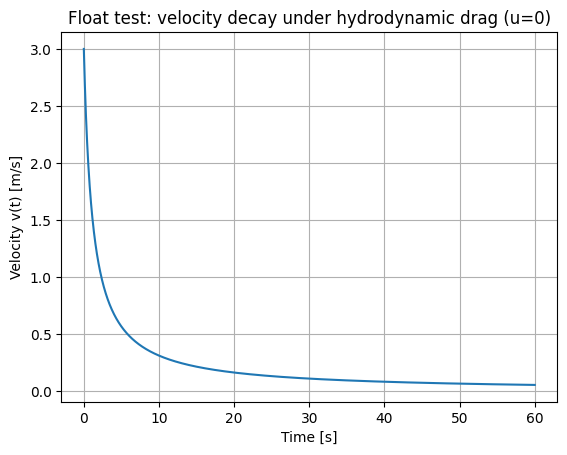

In [ ]:
!pip install casadi
import numpy as np
import matplotlib.pyplot as plt
from casadi import SX, vertcat, Function, integrator

# -----------------------------
# Parameters (from the project sheet)
# -----------------------------
gamma = 0.5        # fraction of force contributing to propulsion
cw = 2.0           # drag coefficient
A = 0.02           # frontal area [m^2]
beta = 0.2         # body efficiency
rho = 997.0        # water density [kg/m^3]
m = 70.0           # swimmer mass [kg]


Emax_al = 1000e3   # 1000 kJ → J
F0 = 0.0           # initial fatigue
Eal0 = Emax_al     # full alactacid energy


# -----------------------------
# States: x = [s, v, Eal, F]
# Input: u (propulsion force)
# Float test: u = 0
# -----------------------------
x = SX.sym("x", 4)
s, v, Eal, F = x[0], x[1], x[2], x[3]
u = SX.sym("u")

drag = 0.5 * rho * cw * A * v**2
sdot = v
vdot = (gamma*u - drag) / m

# No effort => no power usage => keep energy/fatigue constant in float test
Ealdot = 0
Fdot = 0

xdot = vertcat(sdot, vdot, Ealdot, Fdot)

f = Function("f", [x, u], [xdot])

# -----------------------------
# Build integrator (RK4)
# -----------------------------
dt = 0.02  # time step (s)
dae = {"x": x, "p": u, "ode": f(x, u)}
I = integrator("I", "rk", dae, {"tf": dt})

# -----------------------------
# Simulate until v ~ 0
# -----------------------------
xk = np.array([0.0, 3.0, Eal0, F0])  # s0=0, v0=3 m/s, full Eal, no fatigue
uk = 0.0                            # no effort

t_hist = [0.0]
s_hist = [xk[0]]
v_hist = [xk[1]]

t = 0.0
eps = 1e-3
t_max = 60.0  # safety stop

while xk[1] > eps and t < t_max:
    res = I(x0=xk, p=uk)
    xk = np.array(res["xf"]).astype(float).reshape(-1)
    t += dt

    t_hist.append(t)
    s_hist.append(xk[0])
    v_hist.append(xk[1])

print(f"Stopped at t ≈ {t:.2f} s")
print(f"Floating distance until v≈0: s ≈ {xk[0]:.2f} m")

# -----------------------------
# Plot velocity profile
# -----------------------------
plt.figure()
plt.plot(t_hist, v_hist)
plt.xlabel("Time [s]")
plt.ylabel("Velocity v(t) [m/s]")
plt.title("Float test: velocity decay under hydrodynamic drag (u=0)")
plt.grid(True)
plt.show()